In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.2.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.2.1
numpy 1.18.5
pandas 1.0.4
sklearn 0.23.1
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [11]:
imdb = keras.datasets.imdb
vocab_size = 10000
index_from = 3
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words = vocab_size, index_from = index_from)

In [12]:
word_index = imdb.get_word_index()
print(len(word_index))

88584


In [13]:
word_index = {k:(v+3) for k, v in word_index.items()}

In [14]:
word_index['<PAD>'] = 0
word_index['<START>'] = 1
word_index['<UNK>'] = 2
word_index['<END>'] = 3

reverse_word_index = dict(
    [(value, key) for key, value in word_index.items()])

def decode_review(text_ids):
    return ' '.join(
        [reverse_word_index.get(word_id, "<UNK>") for word_id in text_ids])

decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [15]:
max_length = 500

train_data = keras.preprocessing.sequence.pad_sequences(
    train_data, # list of list
    value = word_index['<PAD>'],
    padding = 'post', # post, pre
    maxlen = max_length)

test_data = keras.preprocessing.sequence.pad_sequences(
    test_data, # list of list
    value = word_index['<PAD>'],
    padding = 'post', # post, pre
    maxlen = max_length)

print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

In [16]:
embedding_dim = 16
batch_size = 512
#相对于之前主要改的是这里
single_rnn_model = keras.models.Sequential([
    # 1. define matrix: [vocab_size, embedding_dim]
    # 2. [1,2,3,4..], max_length * embedding_dim
    # 3. batch_size * max_length * embedding_dim
    keras.layers.Embedding(vocab_size, embedding_dim,
                           input_length = max_length),
    # return_sequences是返回输出序列中的最后一个输出还是完整序列,False就是返回最后一个
    keras.layers.SimpleRNN(units = 64, return_sequences = False),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

single_rnn_model.summary()
single_rnn_model.compile(optimizer = 'adam',
                         loss = 'binary_crossentropy',
                         metrics = ['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 16)           160000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                5184      
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 169,409
Trainable params: 169,409
Non-trainable params: 0
_________________________________________________________________


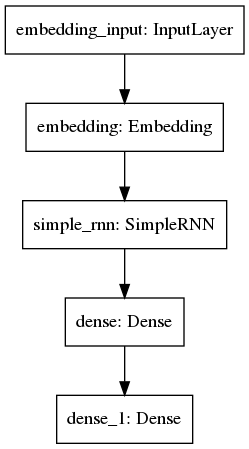

In [19]:
from tensorflow.keras.utils import plot_model

plot_model(single_rnn_model)

In [17]:
single_rnn_model.variables

[<tf.Variable 'embedding/embeddings:0' shape=(10000, 16) dtype=float32, numpy=
 array([[ 1.28735937e-02, -2.45094299e-04,  4.40155528e-02, ...,
         -1.48074999e-02,  1.91386975e-02, -2.43446473e-02],
        [ 2.48066820e-02, -4.15473580e-02, -3.76829021e-02, ...,
         -1.77775398e-02, -1.46606341e-02, -2.03414913e-02],
        [-4.92545739e-02, -2.60585193e-02, -2.20535398e-02, ...,
         -1.10414140e-02, -4.09959182e-02,  7.50074536e-03],
        ...,
        [ 4.58131693e-02,  2.84721889e-02, -4.11869884e-02, ...,
          4.10112031e-02, -8.40745866e-04,  1.30773075e-02],
        [-3.53412516e-02,  3.76076624e-03,  4.07973863e-02, ...,
          4.52702679e-02,  3.57377045e-02,  1.56761743e-02],
        [-4.38112020e-03,  1.25294961e-02, -6.05210662e-05, ...,
         -1.49331093e-02,  2.52953656e-02,  8.75412300e-03]], dtype=float32)>,
 <tf.Variable 'simple_rnn/simple_rnn_cell/kernel:0' shape=(16, 64) dtype=float32, numpy=
 array([[ 0.22077367,  0.2508284 , -0.0358937

In [20]:
history_single_rnn = single_rnn_model.fit(
    train_data, train_labels,
    epochs = 30,
    batch_size = batch_size,
    # 我们这里和之前不一样，没有验证集，所以分20%给验证集
    validation_split = 0.2)


Epoch 1/30
40/40 [==============================] - 22s 553ms/step - loss: 0.6939 - accuracy: 0.5022 - val_loss: 0.6935 - val_accuracy: 0.5078
Epoch 2/30
40/40 [==============================] - 19s 478ms/step - loss: 0.6940 - accuracy: 0.5059 - val_loss: 0.6937 - val_accuracy: 0.4978
Epoch 3/30
40/40 [==============================] - 20s 492ms/step - loss: 0.6937 - accuracy: 0.5017 - val_loss: 0.6947 - val_accuracy: 0.4918
Epoch 4/30
40/40 [==============================] - 20s 491ms/step - loss: 0.6940 - accuracy: 0.5026 - val_loss: 0.6957 - val_accuracy: 0.4938
Epoch 5/30
40/40 [==============================] - 19s 470ms/step - loss: 0.6939 - accuracy: 0.5090 - val_loss: 0.6947 - val_accuracy: 0.4858
Epoch 6/30
40/40 [==============================] - 19s 480ms/step - loss: 0.6932 - accuracy: 0.5093 - val_loss: 0.6934 - val_accuracy: 0.4988
Epoch 7/30
40/40 [==============================] - 20s 498ms/step - loss: 0.6926 - accuracy: 0.5067 - val_loss: 0.6959 - val_accuracy: 0.4908

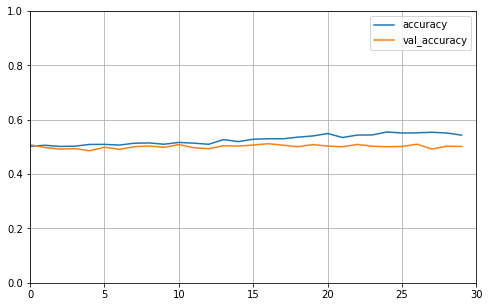

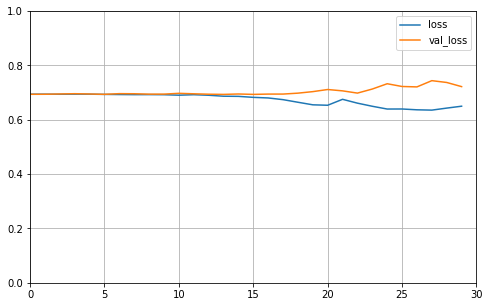

In [21]:
def plot_learning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history_single_rnn, 'accuracy', 30, 0, 1)
plot_learning_curves(history_single_rnn, 'loss', 30, 0, 1)

In [22]:
single_rnn_model.evaluate(
    test_data, test_labels,
    batch_size = batch_size,
    verbose = 0)

[0.7245816588401794, 0.5002800226211548]

In [23]:
#如果我们实现双向的rnn是不是会好一些
embedding_dim = 16
batch_size = 512

model = keras.models.Sequential([
    # 1. define matrix: [vocab_size, embedding_dim]
    # 2. [1,2,3,4..], max_length * embedding_dim
    # 3. batch_size * max_length * embedding_dim
    keras.layers.Embedding(vocab_size, embedding_dim,
                           input_length = max_length),
    # Bidirectional代表双向rnn，前面的计算会收到后面样本的影响
    keras.layers.Bidirectional(
        keras.layers.SimpleRNN(
            units = 64, return_sequences = True)),
    keras.layers.Bidirectional(
        keras.layers.SimpleRNN(
            units = 64, return_sequences = False)),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

model.summary()
model.compile(optimizer = 'adam',
             #  当只有两个标签类别（假定为0和1）时，使用此交叉熵损失
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 128)          10368     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               24704     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 203,393
Trainable params: 203,393
Non-trainable params: 0
_________________________________________________________________


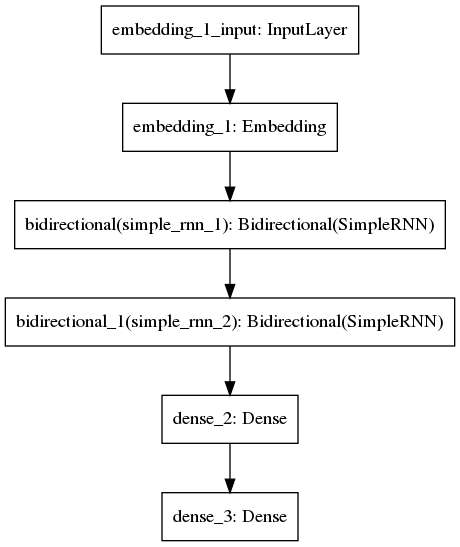

In [24]:
from tensorflow.keras.utils import plot_model

plot_model(model)

In [25]:
model.variables

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 16) dtype=float32, numpy=
 array([[ 0.00518464,  0.02391011,  0.04168283, ..., -0.03651207,
          0.00752375,  0.04998562],
        [-0.0149712 , -0.01663345,  0.04375288, ...,  0.04644593,
          0.01991617,  0.01860202],
        [ 0.04863239, -0.01067047,  0.04880431, ..., -0.02141833,
         -0.04150172,  0.0333736 ],
        ...,
        [-0.0146025 , -0.02803303, -0.04244212, ..., -0.04649568,
          0.04198244, -0.0251209 ],
        [ 0.04343689, -0.04776809,  0.03569771, ..., -0.03752717,
          0.01135906, -0.03687906],
        [-0.01908246, -0.0468595 ,  0.00267122, ..., -0.04487617,
          0.00795536, -0.00402581]], dtype=float32)>,
 <tf.Variable 'bidirectional/forward_simple_rnn_1/simple_rnn_cell_2/kernel:0' shape=(16, 64) dtype=float32, numpy=
 array([[ 0.150875  ,  0.15160683,  0.05209327, ..., -0.20652111,
          0.13472745, -0.12439851],
        [ 0.07635847, -0.21947862, -0.22965549, ..., -0.253

In [26]:
history = model.fit(
    train_data, train_labels,
    epochs = 30,
    batch_size = batch_size,
    validation_split = 0.2)


Epoch 1/30
40/40 [==============================] - 90s 2s/step - loss: 0.6973 - accuracy: 0.4990 - val_loss: 0.7742 - val_accuracy: 0.4928
Epoch 2/30
40/40 [==============================] - 63s 2s/step - loss: 0.6988 - accuracy: 0.5015 - val_loss: 0.6982 - val_accuracy: 0.4962
Epoch 3/30
40/40 [==============================] - 63s 2s/step - loss: 0.7009 - accuracy: 0.5009 - val_loss: 0.6935 - val_accuracy: 0.5176
Epoch 4/30
40/40 [==============================] - 62s 2s/step - loss: 0.6995 - accuracy: 0.4969 - val_loss: 0.6932 - val_accuracy: 0.5074
Epoch 5/30
40/40 [==============================] - 62s 2s/step - loss: 0.6938 - accuracy: 0.5141 - val_loss: 0.6935 - val_accuracy: 0.5078
Epoch 6/30
40/40 [==============================] - 62s 2s/step - loss: 0.6961 - accuracy: 0.5118 - val_loss: 0.6946 - val_accuracy: 0.5056
Epoch 7/30
40/40 [==============================] - 62s 2s/step - loss: 0.6909 - accuracy: 0.5321 - val_loss: 0.6911 - val_accuracy: 0.5204
Epoch 8/30
40/40 [==

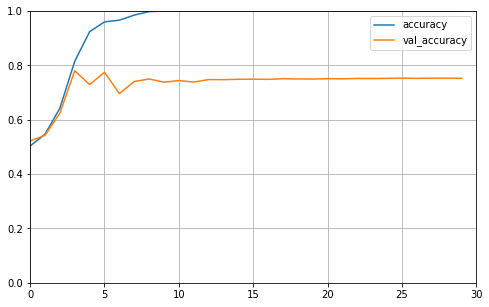

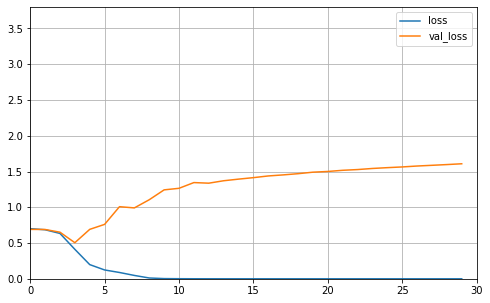

In [13]:
plot_learning_curves(history, 'accuracy', 30, 0, 1)
plot_learning_curves(history, 'loss', 30, 0, 3.8)
#我们发现过拟合了，可能是模型太复杂了，我们改为单层的rnn

In [14]:
embedding_dim = 16
batch_size = 512

bi_rnn_model = keras.models.Sequential([
    # 1. define matrix: [vocab_size, embedding_dim]
    # 2. [1,2,3,4..], max_length * embedding_dim
    # 3. batch_size * max_length * embedding_dim
    keras.layers.Embedding(vocab_size, embedding_dim,
                           input_length = max_length),
    keras.layers.Bidirectional(
        keras.layers.SimpleRNN(
            units = 32, return_sequences = False)),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

bi_rnn_model.summary()
bi_rnn_model.compile(optimizer = 'adam',
                     loss = 'binary_crossentropy',
                     metrics = ['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 16)           160000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                3136      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 165,249
Trainable params: 165,249
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = bi_rnn_model.fit(
    train_data, train_labels,
    epochs = 30,
    batch_size = batch_size,
    validation_split = 0.2)

Epoch 1/30
40/40 [==============================] - 11s 266ms/step - loss: 0.6934 - accuracy: 0.5081 - val_loss: 0.6931 - val_accuracy: 0.5044
Epoch 2/30
40/40 [==============================] - 11s 270ms/step - loss: 0.6911 - accuracy: 0.5257 - val_loss: 0.6943 - val_accuracy: 0.5052
Epoch 3/30
40/40 [==============================] - 11s 267ms/step - loss: 0.6829 - accuracy: 0.5695 - val_loss: 0.6911 - val_accuracy: 0.5278
Epoch 4/30
40/40 [==============================] - 11s 267ms/step - loss: 0.6401 - accuracy: 0.6497 - val_loss: 0.6049 - val_accuracy: 0.6806
Epoch 5/30
40/40 [==============================] - 11s 272ms/step - loss: 0.4174 - accuracy: 0.8169 - val_loss: 0.6208 - val_accuracy: 0.7310
Epoch 6/30
40/40 [==============================] - 11s 264ms/step - loss: 0.2914 - accuracy: 0.8842 - val_loss: 0.4649 - val_accuracy: 0.8022
Epoch 7/30
40/40 [==============================] - 11s 267ms/step - loss: 0.1495 - accuracy: 0.9477 - val_loss: 0.4812 - val_accuracy: 0.8198

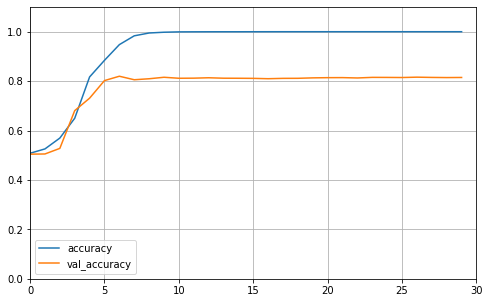

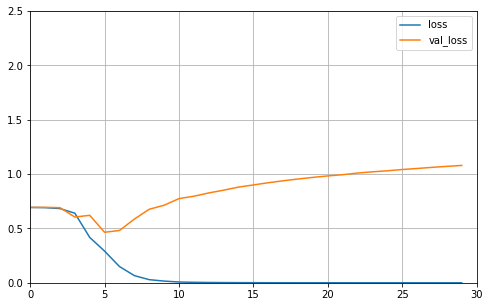

In [16]:
plot_learning_curves(history, 'accuracy', 30, 0, 1.1)
plot_learning_curves(history, 'loss', 30, 0, 2.5)

In [17]:
bi_rnn_model.evaluate(test_data, test_labels, batch_size = batch_size, verbose = 0)

[1.2384063005447388, 0.7864800095558167]

In [18]:
#最终效果变好了，但是仍然过拟合，过拟合说明一点我们模型很强大

In [6]:
#就是前面的交叉熵的损失
y_true = [[0, 1]]
y_pred = [[0.6, 0.4]]
loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
# assert loss.shape == (2,)
loss.numpy()

array([0.9162905], dtype=float32)

In [10]:
1*np.log(0.4)

-0.916290731874155